In [1]:
dryadDir = 'C:/code/miniscope-analysis-mek/InterneuronInhibNAc/InterneuronInhibNAc/dryad/'
figDataSaveDir = r"C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data"

In [2]:
import pandas as pd
df = pd.read_excel(dryadDir + "/final_IEM_data.xlsx")

import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem, ttest_ind, ttest_1samp, ttest_rel, ks_2samp, f_oneway
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.api as sm


In [3]:
# Remove rows where 'Animal_num' is not a number
df = df[pd.to_numeric(df['Animal_num'], errors='coerce').notnull()]
df = df[df['included?'] != 'N']

### partner preference

C:\Users\ephys\AppData\Local\Temp\ipykernel_10076\4023412567.py:151: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='Ctrl_expt', y='percent_phuddle', data=plot_data, palette=colors, size=8, ax=ax)


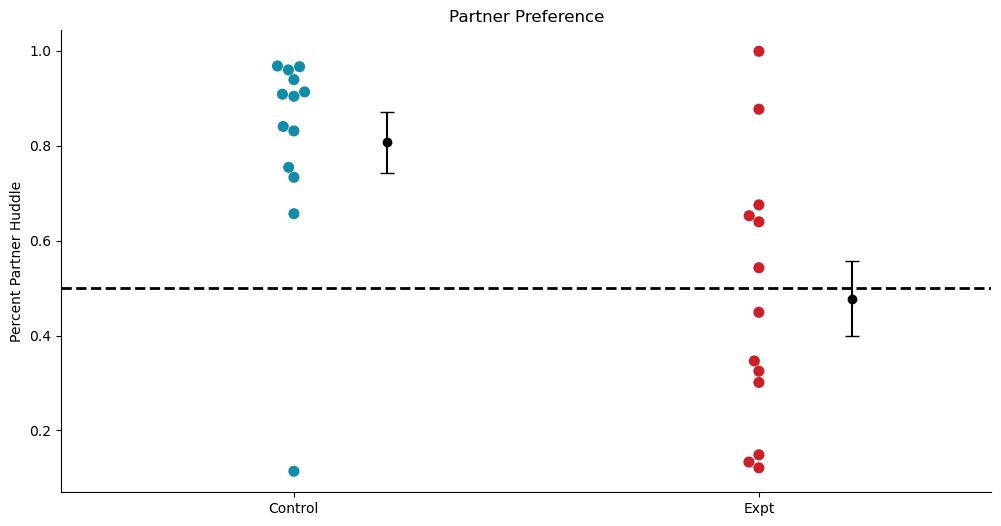

C:\Users\ephys\AppData\Local\Temp\ipykernel_10076\4023412567.py:151: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='Ctrl_expt', y='percent_phuddle', data=plot_data, palette=colors, size=8, ax=ax)


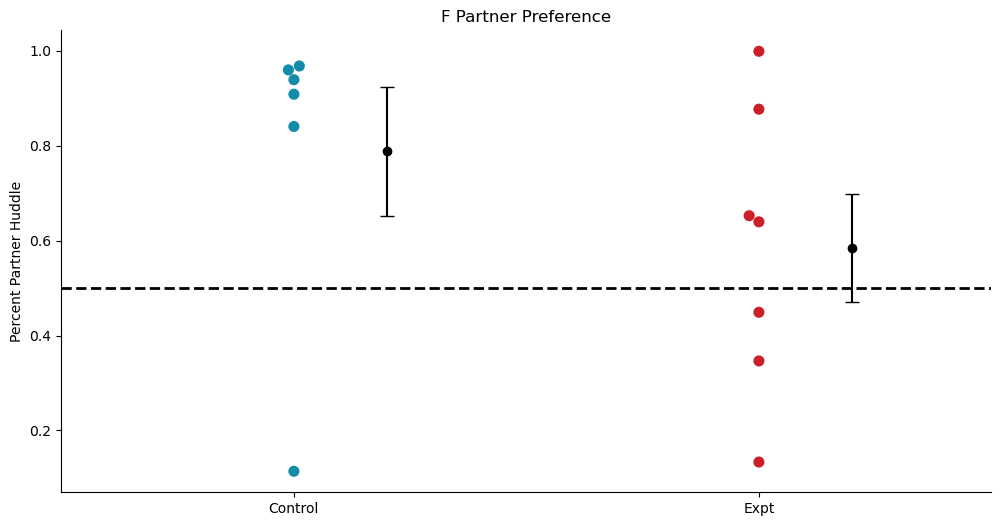

C:\Users\ephys\AppData\Local\Temp\ipykernel_10076\4023412567.py:151: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='Ctrl_expt', y='percent_phuddle', data=plot_data, palette=colors, size=8, ax=ax)


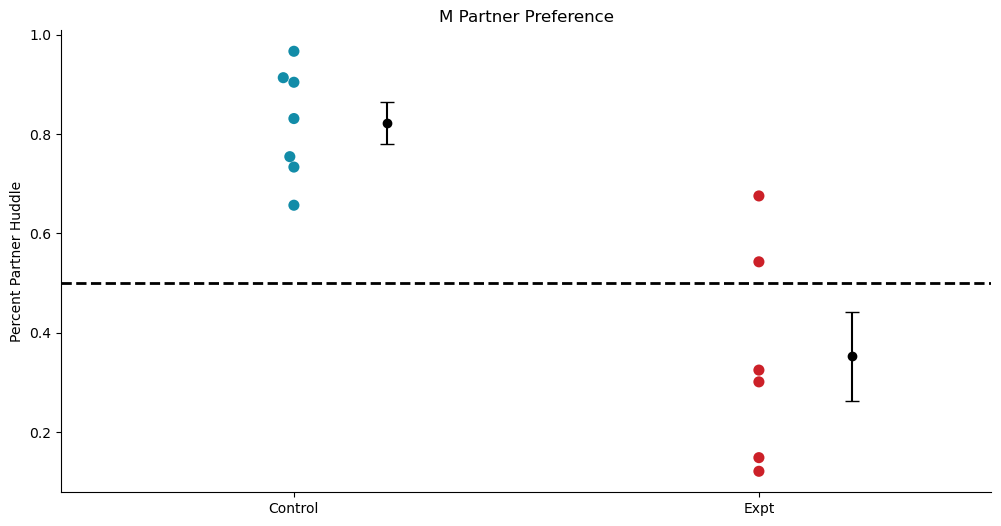

C:\Users\ephys\AppData\Local\Temp\ipykernel_10076\4023412567.py:35: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='Group', y='percent_phuddle', data=plot_data, order=order,



Group Summary Statistics:
------------------------

Control_F:
N = 6
Mean = 0.788
SD = 0.334
Range: 0.114 to 0.968

Control_M:
N = 7
Mean = 0.823
SD = 0.112
Range: 0.657 to 0.966

Expt_F:
N = 7
Mean = 0.585
SD = 0.301
Range: 0.133 to 0.999

Expt_M:
N = 6
Mean = 0.352
SD = 0.219
Range: 0.121 to 0.675

Raw drug effect (ignoring sex):
Control mean: 0.807
Expt mean: 0.478
Raw difference: -0.329

Model 1: Main Effects Only
-------------------------
           Coefficient  Std Error  t-value   P-value
Intercept       0.8602     0.0900   9.5570  1.78e-09
drug           -0.3367     0.1015  -3.3188    0.0030
sex            -0.0992     0.1015  -0.9776    0.3385

Model 2: Full Model with Interaction
----------------------------------
           Coefficient  Std Error  t-value   P-value
Intercept       0.7882     0.1035   7.6146  1.33e-07
drug           -0.2030     0.1411  -1.4392    0.1642
sex             0.0345     0.1411   0.2447    0.8089
drug:sex       -0.2674     0.1995  -1.3404    0.1938


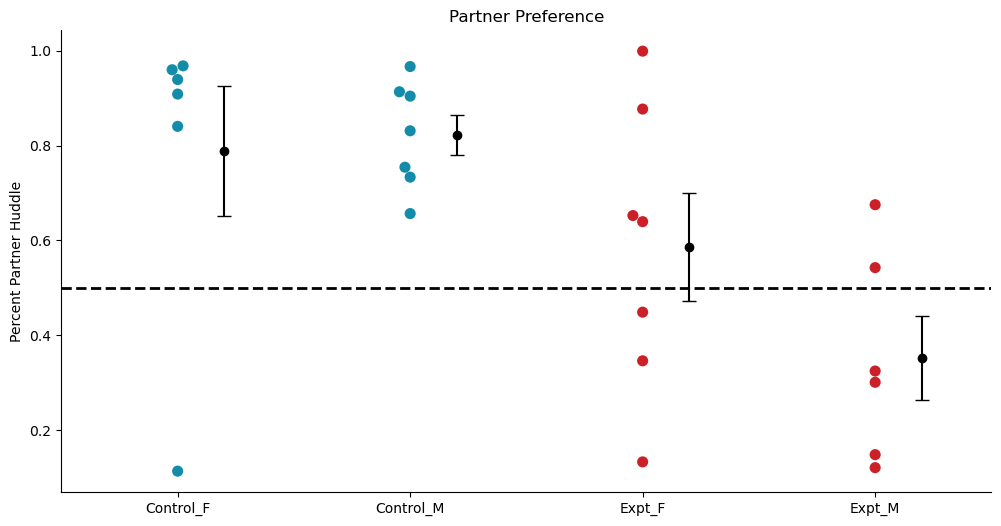

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x229d1c431f0>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x229d1c43f70>)

In [4]:
def create_ppref_plot(df, save_dir, gender=None):
    # Ensure save_dir exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Filter data by gender if specified
    if gender == 'F_M':
        plot_data = df.copy()
        plot_data['Group'] = plot_data['Ctrl_expt'].astype(str) + '_' + plot_data['M_or_F'].astype(str)
        order = ['Control_F', 'Control_M', 'Expt_F', 'Expt_M']
    elif gender:
        plot_data = df[df['M_or_F'] == gender]
    else:
        plot_data = df
    
    # Prepare data for CSV output based on group structure
    if gender == 'F_M':
        csv_data = {group: plot_data[plot_data['Group'] == group]['percent_phuddle'].reset_index(drop=True) for group in order}
        csv_output = pd.DataFrame(csv_data)
    else:
        control_data = plot_data[plot_data['Ctrl_expt'] == 'Control']['percent_phuddle'].reset_index(drop=True)
        expt_data = plot_data[plot_data['Ctrl_expt'] == 'Expt']['percent_phuddle'].reset_index(drop=True)
        csv_output = pd.DataFrame({'Control': control_data, 'Expt': expt_data})
    
    # Save plot data to CSV
    csv_filename = os.path.join(save_dir, f"ppref_plot_data{('_' + gender) if gender else ''}.csv")
    csv_output.to_csv(csv_filename, index=False)
    
    # Set color palette
    colors = {'Control': '#128CA8', 'Expt': '#CC2028'}
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    if gender == 'F_M':
        sns.swarmplot(x='Group', y='percent_phuddle', data=plot_data, order=order, 
                     palette=[colors['Control'], colors['Control'], colors['Expt'], colors['Expt']], 
                     size=8, ax=ax)
        
        # Calculate means and SEMs excluding NaN values
        means = []
        ses = []
        for group in order:
            group_data = plot_data[plot_data['Group'] == group]['percent_phuddle'].dropna()
            means.append(group_data.mean())
            # Only calculate SEM if we have more than 1 non-NaN value
            ses.append(sem(group_data) if len(group_data) > 1 else 0)
        
        # Add means and SEM to the right
        for i, (mean, se) in enumerate(zip(means, ses)):
            if not np.isnan(mean):  # Only plot if mean is not NaN
                x_position = i + 0.2  # Offset for mean and SEM
                ax.errorbar(x=x_position, y=mean, yerr=se, fmt='o', color='black', capsize=5, elinewidth=1.5)
        
        # Add diagnostic information
        print("\nGroup Summary Statistics:")
        print("------------------------")
        for group in order:
            group_data = plot_data[plot_data['Group'] == group]['percent_phuddle'].dropna()
            print(f"\n{group}:")
            print(f"N = {len(group_data)}")
            print(f"Mean = {group_data.mean():.3f}")
            print(f"SD = {group_data.std():.3f}")
            print(f"Range: {group_data.min():.3f} to {group_data.max():.3f}")
        
        # Prepare data for model
        model_data = plot_data.copy()
        
        # Effect coding for predictors
        model_data['drug'] = (model_data['Ctrl_expt'] == 'Expt').astype(int)  # 0=Control, 1=Expt
        model_data['sex'] = (model_data['M_or_F'] == 'M').astype(int)  # 0=F, 1=M
        
        # Calculate raw drug effect (ignoring sex)
        control_mean = model_data[model_data['drug'] == 0]['percent_phuddle'].mean()
        expt_mean = model_data[model_data['drug'] == 1]['percent_phuddle'].mean()
        print(f"\nRaw drug effect (ignoring sex):")
        print(f"Control mean: {control_mean:.3f}")
        print(f"Expt mean: {expt_mean:.3f}")
        print(f"Raw difference: {expt_mean - control_mean:.3f}")
        
        # Fit both models
        import statsmodels.formula.api as smf
        
        # Model 1: Main effects only
        model1 = smf.ols('percent_phuddle ~ drug + sex', data=model_data)
        results1 = model1.fit()
        
        # Model 2: Full model with interaction
        model2 = smf.ols('percent_phuddle ~ drug + sex + drug:sex', data=model_data)
        results2 = model2.fit()
        
        # Function to format coefficient table
        def format_coef_table(results):
            coef_table = pd.DataFrame({
                'Coefficient': results.params,
                'Std Error': results.bse,
                't-value': results.tvalues,
                'P-value': results.pvalues
            })
            
            # Format p-values
            coef_table['P-value'] = coef_table['P-value'].apply(
                lambda x: f"{x:.2e}" if x < 0.001 else f"{x:.4f}")
            
            # Round other columns
            for col in ['Coefficient', 'Std Error', 't-value']:
                coef_table[col] = coef_table[col].round(4)
            
            return coef_table
        
        # Print results for both models
        print("\nModel 1: Main Effects Only")
        print("-------------------------")
        print(format_coef_table(results1))
        
        print("\nModel 2: Full Model with Interaction")
        print("----------------------------------")
        print(format_coef_table(results2))
        
        # Save statistical results
        stats_filename = os.path.join(save_dir, f"ppref_stats_FM.txt")
        with open(stats_filename, 'w') as f:
            f.write("Linear Model Results for Sex and Drug Effects\n")
            f.write("==========================================\n\n")
            
            f.write("MODEL 1: Main Effects Only\n")
            f.write("-------------------------\n")
            f.write("Predictors:\n")
            f.write("drug: Effect of IEM-1460 (0=Control, 1=IEM-1460)\n")
            f.write("sex: Effect of sex (0=Female, 1=Male)\n\n")
            f.write(format_coef_table(results1).to_string())
            f.write("\n\nModel 1 Summary:\n")
            f.write(f"R-squared: {results1.rsquared:.3f}\n")
            f.write(f"Adjusted R-squared: {results1.rsquared_adj:.3f}\n")
            f.write(f"F-statistic: {results1.fvalue:.3f}\n")
            f.write(f"F-test p-value: {results1.f_pvalue:.4e}\n\n")
            
            f.write("\nMODEL 2: Full Model with Interaction\n")
            f.write("----------------------------------\n")
            f.write("Predictors:\n")
            f.write("drug: Effect of IEM-1460 (0=Control, 1=IEM-1460)\n")
            f.write("sex: Effect of sex (0=Female, 1=Male)\n")
            f.write("drug:sex: Interaction between treatment and sex\n\n")
            f.write(format_coef_table(results2).to_string())
            f.write("\n\nModel 2 Summary:\n")
            f.write(f"R-squared: {results2.rsquared:.3f}\n")
            f.write(f"Adjusted R-squared: {results2.rsquared_adj:.3f}\n")
            f.write(f"F-statistic: {results2.fvalue:.3f}\n")
            f.write(f"F-test p-value: {results2.f_pvalue:.4e}\n")
            
    else:
        sns.swarmplot(x='Ctrl_expt', y='percent_phuddle', data=plot_data, palette=colors, size=8, ax=ax)
        
        # Calculate means and SEMs excluding NaN values
        control_clean = control_data.dropna()
        expt_clean = expt_data.dropna()
        
        mean_control = control_clean.mean()
        mean_expt = expt_clean.mean()
        se_control = sem(control_clean) if len(control_clean) > 1 else 0
        se_expt = sem(expt_clean) if len(expt_clean) > 1 else 0
        
        # Add means and SEM to the right
        if not np.isnan(mean_control):
            ax.errorbar(x=0.2, y=mean_control, yerr=se_control, fmt='o', color='black', capsize=5, elinewidth=1.5)
        if not np.isnan(mean_expt):
            ax.errorbar(x=1.2, y=mean_expt, yerr=se_expt, fmt='o', color='black', capsize=5, elinewidth=1.5)
    
    ax.axhline(0.5, color='black', linestyle='--', linewidth=2)
    
    # Set title and labels
    gender_title = f"{gender} " if gender and gender != 'F_M' else ""
    ax.set_title(f'{gender_title}Partner Preference')
    ax.set_xlabel('')
    ax.set_ylabel('Percent Partner Huddle')
    
    ax.set_xlim(-0.5, 3.5 if gender == 'F_M' else 1.5)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Make remaining spines black
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    # Ensure ticks are only on the bottom and left
    ax.tick_params(top=False, right=False)
    
    # Save the plot
    gender_suffix = f"_{gender.lower()}" if gender else ""
    plot_filename = os.path.join(save_dir, f"ppref_plot{gender_suffix}.svg")
    plt.savefig(plot_filename, format='svg', bbox_inches='tight')
    plot_filename = os.path.join(save_dir, f"ppref_plot{gender_suffix}.png")
    plt.savefig(plot_filename, format='png', bbox_inches='tight')
    plt.show()
    
    # Return both model results if F_M case
    if gender == 'F_M':
        return results1, results2

# Create plots for all data, females only, males only, and combined female/male
create_ppref_plot(df, figDataSaveDir + '/pharmacology_only')  # All data
create_ppref_plot(df, figDataSaveDir + '/pharmacology_only', gender='F')  # Females only
create_ppref_plot(df, figDataSaveDir + '/pharmacology_only', gender='M')  # Males only
create_ppref_plot(df, figDataSaveDir + '/pharmacology_only', gender='F_M')  # Combined female and male plot


### huddle time

Control - Paired t-test: t(12) = 3.67, p = 0.0032
Expt - Paired t-test: t(12) = -0.22, p = 0.8266


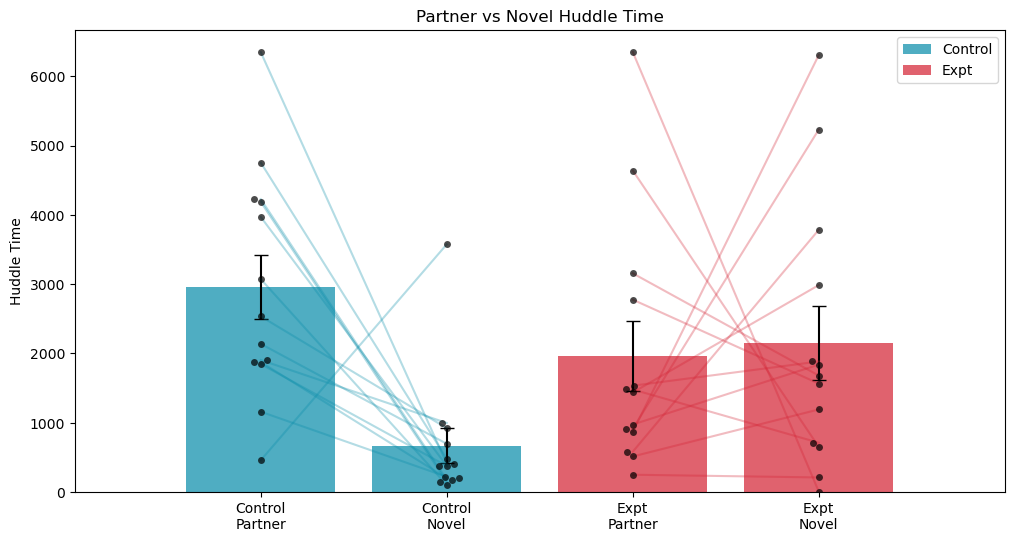

C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                           Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            Huddle_Time 
No. Observations:            52                 Method:                        REML        
No. Groups:                  26                 Scale:                         2592172.9549
Min. group size:             2                  Log-Likelihood:                -428.4848   
Max. group size:             2                  Converged:                     No          
Mean group size:             2.0                                                           
-------------------------------------------------------------------------------------------
                                           Coef.   Std.Err.   z    P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------------------------
Intercept                                  667.645  454.305  1.470 0.142  -222.777 1558.066
Ctrl_expt[T.Exp

C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 3.942937
  warnings.warn(msg, ConvergenceWarning)
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [5]:
huddle_time_partner = df['huddle_time_partner']
huddle_time_novel = df['huddle_time_novel']
ctrl_expt = df['Ctrl_expt']

plot_data = pd.DataFrame({
    'Animal': range(len(df)),
    'Ctrl_expt': ctrl_expt,
    'Partner': huddle_time_partner,
    'Novel': huddle_time_novel
})

# Reshape the data for LME model and plotting
plot_data_melted = pd.melt(plot_data, id_vars=['Animal', 'Ctrl_expt'], 
                           value_vars=['Partner', 'Novel'], 
                           var_name='Huddle_Type', value_name='Huddle_Time')

# Set color palette
colors = {'Control': '#048BA8', 'Expt': '#D31F30'}

# Create the plot
plt.figure(figsize=(12, 6))

# Define x-positions for the bars
x_positions = [0, 1, 2, 3]
x_labels = ['Control\nPartner', 'Control\nNovel', 'Expt\nPartner', 'Expt\nNovel']

# Plot bars and individual data points
for i, (group, huddle_type) in enumerate(zip(['Control', 'Control', 'Expt', 'Expt'], ['Partner', 'Novel', 'Partner', 'Novel'])):
    group_data = plot_data_melted[(plot_data_melted['Ctrl_expt'] == group) & (plot_data_melted['Huddle_Type'] == huddle_type)]
    
    # Plot bar
    mean = group_data['Huddle_Time'].mean()
    se = sem(group_data['Huddle_Time'])
    plt.bar(x_positions[i], mean, yerr=se, capsize=5, color=colors[group], alpha=0.7, width=0.8)
    
    # Plot individual data points
    sns.swarmplot(x=[x_positions[i]] * len(group_data), y='Huddle_Time', data=group_data, 
                  color='black', size=5, alpha=0.7)

# Plot lines connecting partner and novel for each animal
for group, x_offset in zip(['Control', 'Expt'], [0, 2]):
    group_data = plot_data[plot_data['Ctrl_expt'] == group]
    for _, animal_data in group_data.iterrows():
        plt.plot([x_offset, x_offset + 1], [animal_data['Partner'], animal_data['Novel']], 
                 color=colors[group], alpha=0.3)

# Run paired t-test for each group
for group in ['Control', 'Expt']:
    group_data = plot_data[plot_data['Ctrl_expt'] == group]
    t_stat, p_value = ttest_rel(group_data['Partner'], group_data['Novel'])
    degrees_of_freedom = len(group_data['Partner']) - 1
    print(f"{group} - Paired t-test: t({degrees_of_freedom}) = {t_stat:.2f}, p = {p_value:.4f}")


plt.title('Partner vs Novel Huddle Time')
plt.ylabel('Huddle Time')
plt.xticks(x_positions, x_labels)
plt.xlim(-1, 4)

# Add legend
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors['Control'], alpha=0.7, label='Control'),
                   plt.Rectangle((0,0),1,1, facecolor=colors['Expt'], alpha=0.7, label='Expt')]
plt.legend(handles=legend_elements, loc='upper right')

# Create directory if it doesn't exist
save_dir = "C:/code/miniscope-analysis-mek/InterneuronInhibNAc/InterneuronInhibNAc/figs/pharm"
os.makedirs(save_dir, exist_ok=True)

# Save the plot
plt.savefig(os.path.join(figDataSaveDir, 'pharmacology_only', "partner_novel_huddle.svg"), format='svg')
plt.savefig(os.path.join(figDataSaveDir, 'pharmacology_only', "partner_novel_huddle.png"), format='png')

# Show the plot
plt.show()

# Linear Mixed Effects Model
# Fit LME with random intercept for Animal, fixed effects for Ctrl_expt and Huddle_Type, and interaction term
lme_model = smf.mixedlm("Huddle_Time ~ Ctrl_expt * Huddle_Type", 
                        plot_data_melted, 
                        groups=plot_data_melted["Animal"])
lme_result = lme_model.fit()

# Print the summary of the model
print(lme_result.summary())

# Save data to CSV in the same location as the figure
csv_filename = figDataSaveDir + '/pharmacology_only' + "/partner_novel_huddle_data.csv"
plot_data.to_csv(csv_filename, index=False)
print(f"Data saved to CSV file: {csv_filename}")


t(24) = -0.73, p = 0.473


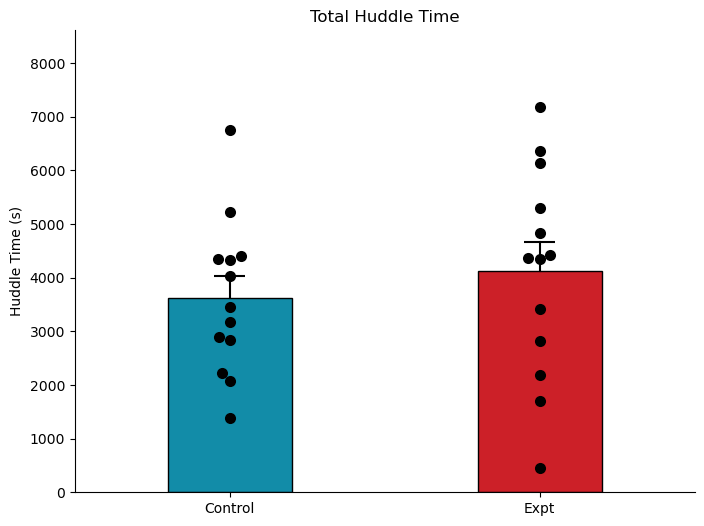

In [6]:
def plot_huddle_time_total(df, save_dir):
    
    # Ensure save_dir exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Remove NaN values
    df = df.dropna(subset=['huddle_time_total', 'Ctrl_expt'])
    
    # Extract relevant columns
    huddle_time_total = df['huddle_time_total']
    ctrl_expt = df['Ctrl_expt']
    df['Ctrl_expt'] = pd.Categorical(ctrl_expt)
    plot_data = pd.DataFrame({'Huddle Time Total': huddle_time_total, 'Ctrl_expt': ctrl_expt})
    
    # Separate control and experimental data
    control_data = plot_data[plot_data['Ctrl_expt'] == 'Control']['Huddle Time Total'].reset_index(drop=True)
    expt_data = plot_data[plot_data['Ctrl_expt'] == 'Expt']['Huddle Time Total'].reset_index(drop=True)
    csv_output = pd.DataFrame({'Control': control_data, 'Expt': expt_data})
    
    # Save plot data to CSV
    csv_filename = os.path.join(save_dir, "huddle_time_total_data.csv")
    csv_output.to_csv(csv_filename, index=False)
    
    # Set color palette
    colors = {'Control': '#128CA8', 'Expt': '#CC2028'}
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot data points in black
    sns.swarmplot(x='Ctrl_expt', y='Huddle Time Total', data=plot_data, color='black', size=8, ax=ax)
    
    # Calculate means and standard errors
    mean_control = np.mean(control_data)
    mean_expt = np.mean(expt_data)
    se_control = sem(control_data) if len(control_data) > 1 else 0
    se_expt = sem(expt_data) if len(expt_data) > 1 else 0
    
    # Plot bars with a black outline
    bar_width = 0.4
    ax.bar(x=0, height=mean_control, color=colors['Control'], edgecolor='black', width=bar_width, zorder=2)
    ax.bar(x=1, height=mean_expt, color=colors['Expt'], edgecolor='black', width=bar_width, zorder=2)
    
    # Add SEM lines with horizontal ticks only above the bar
    if se_control > 0:
        ax.plot([0, 0], [mean_control, mean_control + se_control], color='black', linewidth=1.5, zorder=3)
        ax.hlines(mean_control + se_control, -0.05, 0.05, color='black', linewidth=1.5, zorder=3)
    if se_expt > 0:
        ax.plot([1, 1], [mean_expt, mean_expt + se_expt], color='black', linewidth=1.5, zorder=3)
        ax.hlines(mean_expt + se_expt, 0.95, 1.05, color='black', linewidth=1.5, zorder=3)
    
    # Run t-test and print results
    t_stat, p_value = ttest_ind(control_data, expt_data)
    n_control = len(control_data)
    n_expt = len(expt_data)
    total_n = n_control + n_expt
    print(f't({total_n-2}) = {t_stat:.2f}, p = {p_value:.3f}')
    
    # Plot formatting
    ax.set_title('Total Huddle Time')
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(0, max(huddle_time_total) * 1.2)
    ax.set_xlabel('')
    ax.set_ylabel('Huddle Time (s)')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Control', 'Expt'])
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Make remaining spines black
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    # Adjust tick parameters
    ax.tick_params(axis='y', colors='black')
    ax.tick_params(axis='x', colors='black')
    
    # Ensure ticks are only on the bottom and left
    ax.tick_params(top=False, right=False)
    
    # Save plot as SVG and PNG
    plt.savefig(os.path.join(save_dir, "huddle_time_total.svg"), format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(save_dir, "huddle_time_total.png"), format='png', bbox_inches='tight')
    plt.show()

# Call the function with your DataFrame
plot_huddle_time_total(df, figDataSaveDir + '/pharmacology_only')


### mating

In [7]:
def plot_mating_bouts(df, save_dir):
    # Ensure save_dir exists
    os.makedirs(save_dir, exist_ok=True)

    # Remove NaN values
    df = df.dropna(subset=['Mating Bouts', 'Ctrl_expt'])

    # Extract relevant columns
    mating_bouts = df['Mating Bouts']
    ctrl_expt = df['Ctrl_expt']
    plot_data = pd.DataFrame({'Mating Bouts': mating_bouts, 'Ctrl_expt': pd.Categorical(ctrl_expt)})

    # Save cleaned plot data to CSV
    plot_data.to_csv(os.path.join(save_dir, "mating_bouts_data.csv"), index=False)

    # Create plot
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = {'Control': '#128CA8', 'Expt': '#CC2028'}
    sns.swarmplot(x='Ctrl_expt', y='Mating Bouts', data=plot_data, color='black', size=8, ax=ax)

    # Calculate means and SEMs
    control_data = plot_data.loc[plot_data['Ctrl_expt'] == 'Control', 'Mating Bouts']
    expt_data = plot_data.loc[plot_data['Ctrl_expt'] == 'Expt', 'Mating Bouts']

    mean_control = np.mean(control_data)
    mean_expt = np.mean(expt_data)
    se_control = sem(control_data) if len(control_data) > 1 else 0
    se_expt = sem(expt_data) if len(expt_data) > 1 else 0

    # Plot bars with black outline
    ax.bar(x=0, height=mean_control, color=colors['Control'], edgecolor='black', width=0.4, zorder=2)
    ax.bar(x=1, height=mean_expt, color=colors['Expt'], edgecolor='black', width=0.4, zorder=2)

    # Add SEM lines and horizontal ticks above bars
    if se_control > 0:
        ax.plot([0, 0], [mean_control, mean_control + se_control], color='black', linewidth=1.5, zorder=3)
        ax.hlines(mean_control + se_control, -0.05, 0.05, color='black', linewidth=1.5, zorder=3)
    if se_expt > 0:
        ax.plot([1, 1], [mean_expt, mean_expt + se_expt], color='black', linewidth=1.5, zorder=3)
        ax.hlines(mean_expt + se_expt, 0.95, 1.05, color='black', linewidth=1.5, zorder=3)

    # Titles and labels
    ax.set_title('Mating Bouts')
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(0, max(plot_data['Mating Bouts']) * 1.2)
    ax.set_xlabel('')
    ax.set_ylabel('Number of Mating Bouts')
    ax.set_xticklabels(['Control', 'Expt'])

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Make remaining spines black
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    # Ensure ticks are only on the bottom and left
    ax.tick_params(top=False, right=False)

    # Save and show the plot
    plt.savefig(os.path.join(save_dir, "mating_bouts.svg"), format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(save_dir, "mating_bouts.png"), format='png', bbox_inches='tight')
    plt.show()


def plot_mating_latency(df, save_dir):
    # Ensure save_dir exists
    os.makedirs(save_dir, exist_ok=True)

    # Remove NaN values
    df = df.dropna(subset=['Mating latency', 'Ctrl_expt'])

    # Extract relevant columns
    mating_latency = df['Mating latency']
    ctrl_expt = df['Ctrl_expt']
    plot_data = pd.DataFrame({'Mating Latency': mating_latency, 'Ctrl_expt': pd.Categorical(ctrl_expt)})

    # Save cleaned plot data to CSV
    plot_data.to_csv(os.path.join(save_dir, "mating_latency_data.csv"), index=False)

    # Create plot
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = {'Control': '#128CA8', 'Expt': '#CC2028'}
    sns.swarmplot(x='Ctrl_expt', y='Mating Latency', data=plot_data, color='black', size=8, ax=ax)

    # Calculate means and SEMs
    control_data = plot_data.loc[plot_data['Ctrl_expt'] == 'Control', 'Mating Latency']
    expt_data = plot_data.loc[plot_data['Ctrl_expt'] == 'Expt', 'Mating Latency']

    mean_control = np.mean(control_data)
    mean_expt = np.mean(expt_data)
    se_control = sem(control_data) if len(control_data) > 1 else 0
    se_expt = sem(expt_data) if len(expt_data) > 1 else 0

    # Plot bars with black outline
    ax.bar(x=0, height=mean_control, color=colors['Control'], edgecolor='black', width=0.4, zorder=2)
    ax.bar(x=1, height=mean_expt, color=colors['Expt'], edgecolor='black', width=0.4, zorder=2)

    # Add SEM lines and horizontal ticks above bars
    if se_control > 0:
        ax.plot([0, 0], [mean_control, mean_control + se_control], color='black', linewidth=1.5, zorder=3)
        ax.hlines(mean_control + se_control, -0.05, 0.05, color='black', linewidth=1.5, zorder=3)
    if se_expt > 0:
        ax.plot([1, 1], [mean_expt, mean_expt + se_expt], color='black', linewidth=1.5, zorder=3)
        ax.hlines(mean_expt + se_expt, 0.95, 1.05, color='black', linewidth=1.5, zorder=3)

    # Titles and labels
    ax.set_title('Mating Latency')
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(0, max(plot_data['Mating Latency']) * 1.2)
    ax.set_xlabel('')
    ax.set_ylabel('Mating Latency (s)')
    ax.set_xticklabels(['Control', 'Expt'])

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Make remaining spines black
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    # Ensure ticks are only on the bottom and left
    ax.tick_params(top=False, right=False)

    # Save and show the plot
    plt.savefig(os.path.join(save_dir, "mating_latency.svg"), format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(save_dir, "mating_latency.png"), format='png', bbox_inches='tight')
    plt.show()


def plot_mating_latency_cdf(df, save_dir):
    # Ensure save_dir exists
    os.makedirs(save_dir, exist_ok=True)

    # Remove NaN values
    df = df.dropna(subset=['Mating latency', 'Ctrl_expt'])

    mating_latency = df['Mating latency']
    ctrl_expt = df['Ctrl_expt']
    colors = {'Control': '#128CA8', 'Expt': '#CC2028'}

    cdf_data = []

    fig, ax = plt.subplots(figsize=(8, 6))
    for group in ['Control', 'Expt']:
        data = mating_latency[ctrl_expt == group]
        x = np.sort(data)
        y = np.linspace(0, 1, len(x))

        x_plot = np.concatenate(([0], x, [x[-1]]))
        y_plot = np.concatenate(([0], y, [1]))

        ax.step(x_plot, y_plot, where='post', color=colors[group], label=group)

        # Append data for saving
        cdf_data.append(pd.DataFrame({'Latency': x_plot, 'CDF': y_plot, 'Group': group}))

    ax.set_title('CDF of Mating Latency')
    ax.set_xlabel('Mating Latency')
    ax.set_ylabel('Cumulative Probability')
    ax.legend()
    ax.set_ylim(0, 1)
    ax.set_xlim(left=0)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Make remaining spines black
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    # Ensure ticks are only on the bottom and left
    ax.tick_params(top=False, right=False)

    # Save and show the plot
    plt.savefig(os.path.join(save_dir, "mating_latency_cdf.svg"), format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(save_dir, "mating_latency_cdf.png"), format='png', bbox_inches='tight')
    plt.show()

    # Concatenate and save CDF data
    pd.concat(cdf_data).to_csv(os.path.join(save_dir, "mating_latency_cdf_data.csv"), index=False)
    
def compare_mating_latency_cdf(df):
    mating_latency = df['Mating latency']
    ctrl_expt = df['Ctrl_expt']

    control_data = mating_latency[ctrl_expt == 'Control']
    expt_data = mating_latency[ctrl_expt == 'Expt']

    ks_stat, p_value = ks_2samp(control_data, expt_data)
    print(f'KS Statistic = {ks_stat:.3f}, p = {p_value:.3f}')

    return ks_stat, p_value


C:\Users\ephys\AppData\Local\Temp\ipykernel_10076\1189694656.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Control', 'Expt'])


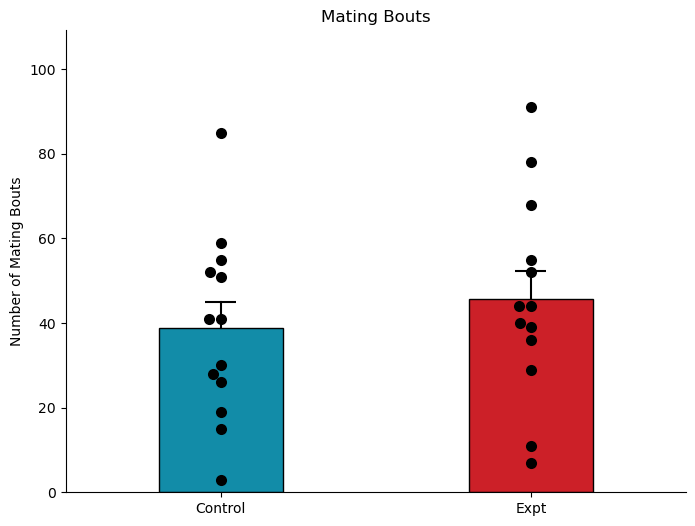

C:\Users\ephys\AppData\Local\Temp\ipykernel_10076\1189694656.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Control', 'Expt'])


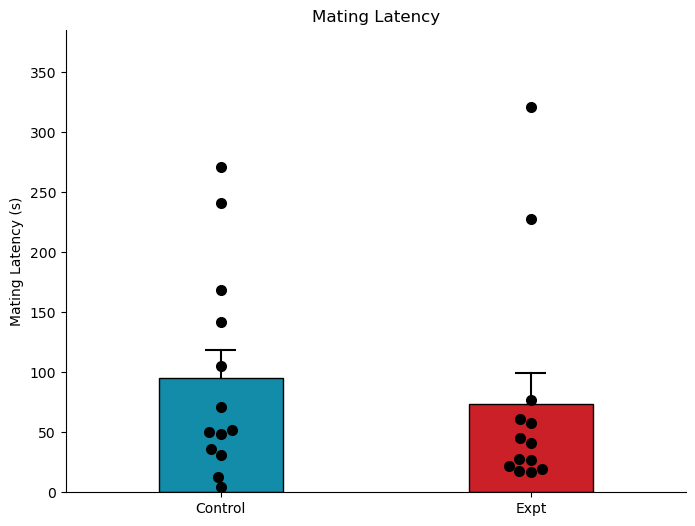

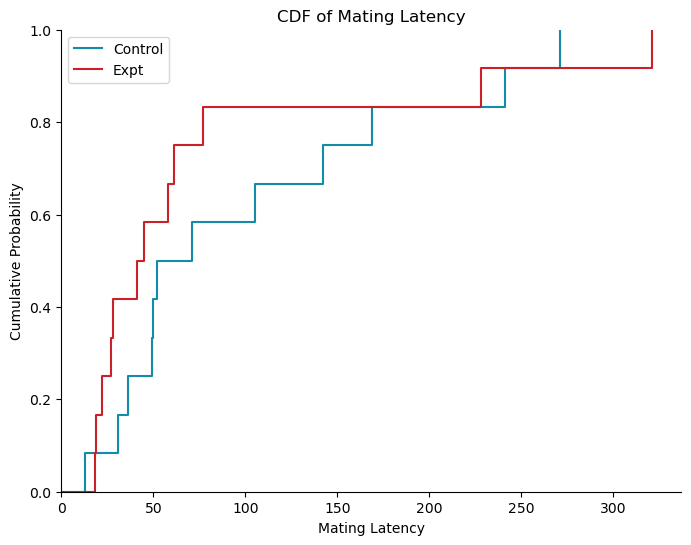

KS Statistic = 0.308, p = 0.588


(0.3076923076923077, 0.5881960656115993)

In [8]:
plot_mating_bouts(df, figDataSaveDir + '/pharmacology_only')
plot_mating_latency(df, figDataSaveDir + '/pharmacology_only')
plot_mating_latency_cdf(df, figDataSaveDir + '/pharmacology_only')
compare_mating_latency_cdf(df)

### locomotion

t(24) = 0.18, p = 0.855


C:\Users\ephys\AppData\Local\Temp\ipykernel_10076\2093160148.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Control', 'Expt'])


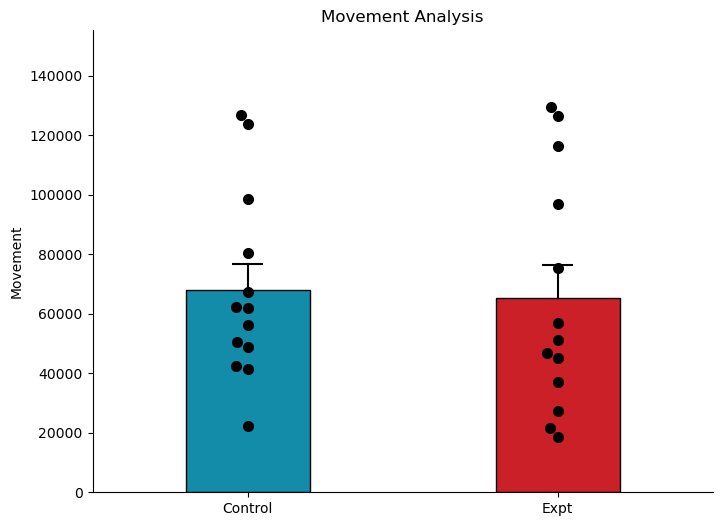

In [9]:
def create_movement_plot(df, save_dir):
    # Ensure save_dir exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Remove NaN values
    df = df.dropna(subset=['Movement', 'Ctrl_expt'])
    
    # Extract relevant columns
    movement = df['Movement']
    ctrl_expt = df['Ctrl_expt']
    plot_data = pd.DataFrame({'Movement': movement, 'Ctrl_expt': pd.Categorical(ctrl_expt)})
    
    # Separate control and experimental data for CSV
    control_data = plot_data[plot_data['Ctrl_expt'] == 'Control']['Movement'].reset_index(drop=True)
    expt_data = plot_data[plot_data['Ctrl_expt'] == 'Expt']['Movement'].reset_index(drop=True)
    csv_output = pd.DataFrame({'Control': control_data, 'Expt': expt_data})
    
    # Save plot data to CSV
    csv_filename = os.path.join(save_dir, "movement_data.csv")
    csv_output.to_csv(csv_filename, index=False)
    
    # Set color palette
    colors = {'Control': '#128CA8', 'Expt': '#CC2028'}
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot black dots
    sns.swarmplot(x='Ctrl_expt', y='Movement', data=plot_data, color='black', size=8, ax=ax)
    
    # Calculate means and standard errors excluding NaN values
    control_clean = control_data.dropna()
    expt_clean = expt_data.dropna()
    
    mean_control = control_clean.mean()
    mean_expt = expt_clean.mean()
    se_control = sem(control_clean) if len(control_clean) > 1 else 0
    se_expt = sem(expt_clean) if len(expt_clean) > 1 else 0
    
    # Plot bars with black outline
    ax.bar(x=0, height=mean_control, color=colors['Control'], edgecolor='black', width=0.4, zorder=2)
    ax.bar(x=1, height=mean_expt, color=colors['Expt'], edgecolor='black', width=0.4, zorder=2)
    
    # Add SEM lines with horizontal ticks only above the bar
    if se_control > 0:
        ax.plot([0, 0], [mean_control, mean_control + se_control], color='black', linewidth=1.5, zorder=3)
        ax.hlines(mean_control + se_control, -0.05, 0.05, color='black', linewidth=1.5, zorder=3)
    if se_expt > 0:
        ax.plot([1, 1], [mean_expt, mean_expt + se_expt], color='black', linewidth=1.5, zorder=3)
        ax.hlines(mean_expt + se_expt, 0.95, 1.05, color='black', linewidth=1.5, zorder=3)
    
    # Run t-test and print results
    if len(control_clean) > 0 and len(expt_clean) > 0:
        t_stat, p_value = ttest_ind(control_clean, expt_clean)
        total_n = len(control_clean) + len(expt_clean)
        print(f't({total_n-2}) = {t_stat:.2f}, p = {p_value:.3f}')
    
    # Set title and labels
    ax.set_title('Movement Analysis')
    ax.set_xlabel('')
    ax.set_ylabel('Movement')
    
    # Set axis limits
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(0, max(plot_data['Movement']) * 1.2)
    
    # Set x-axis labels
    ax.set_xticklabels(['Control', 'Expt'])
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Make remaining spines black
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    # Ensure ticks are only on the bottom and left
    ax.tick_params(top=False, right=False)
    
    # Save and show the plot
    plt.savefig(os.path.join(save_dir, "movement.svg"), format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(save_dir, "movement.png"), format='png', bbox_inches='tight')
    plt.show()
# Create plot for movement data
create_movement_plot(df, figDataSaveDir + '/pharmacology_only')

In [10]:
#anova
formula = 'percent_phuddle ~ C(Ctrl_expt) + C(M_or_F) + C(Ctrl_expt):C(M_or_F)'
model = ols(formula, data=df).fit()
anova_table = sm.stats.anova_lm(model,typ=2)
print(anova_table)


                          sum_sq    df          F    PR(>F)
C(Ctrl_expt)            0.732660   1.0  11.395854  0.002724
C(M_or_F)               0.063569   1.0   0.988759  0.330858
C(Ctrl_expt):C(M_or_F)  0.115518   1.0   1.796783  0.193781
Residual                1.414419  22.0        NaN       NaN
